# 2次遅れ系の周波数応答と時間応答
(c) Copyright 2020 @RR_Inyo

In [1]:
## 準備
%matplotlib inline
from control.matlab import *
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

## システムの定義
2次遅れ系の標準的な伝達関数を下に示す。
$$
G(s) = \frac{\omega_{n}^{2}}{s^{2} + 2 \zeta \omega_{n} s + \omega_{n}^{2}}
$$
ここで，仮に$\omega_{n} = 2 \pi f_{n}$，$f_{n} = 500$ $\mathrm{Hz}$としてボード線図をプロットする。
また，サンプリング周波数$f_{s} = 10$ $\mathrm{kHz}$（サンプリング周期$T_{s} = 100$ $\mu\mathrm{s}$）として双一次変換を適用し，離散系に変換した場合についても示す。
ここでは例として，2次バターワース特性となる$\zeta = 1 / \sqrt{2}$の場合を示す。後述するが，この場合はボード線図においてゲインはピーク値を持たないが，ステップ応答はオーバーシュート<sup>※</sup>を示す。

※ 感染症の爆発的な感染拡大を意味する言葉ではない。

In [2]:
f_n = 500
zeta = 1 / np.sqrt(2)
#zeta = 1 / 4
omega_n = 2 * np.pi * f_n
T_s = 1 / 10e3
 
# 連続時間
G = tf([0, omega_n**2], [1, 2 * zeta * omega_n, omega_n**2])
 
# 離散時間
G_d = c2d(G, T_s, method = 'tustin')

## ボード線図
Python Control Systems Libraryを用いて，下記のように計算できる。

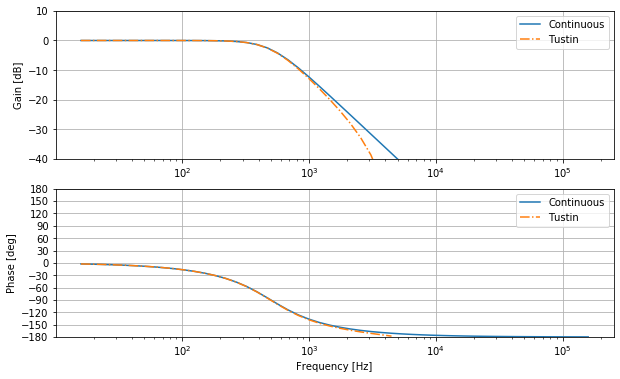

In [3]:
fig, ax = plt.subplots(2, 1, figsize = (10, 6))
 
# 連続時間
gain, phase, omega = bode(G, np.logspace(2, 6), Hz = True, Plot = False)
ax[0].semilogx(omega / (2 * np.pi), 20*np.log10(gain), ls = '-', label = 'Continuous')
ax[1].semilogx(omega / (2 * np.pi), phase * 180 / np.pi, ls = '-', label = 'Continuous')
 
# 離散時間
gain_d, phase_d, omega_d = bode(G_d, np.logspace(2, 6), Hz = True, Plot = False)
ax[0].semilogx(omega_d / (2 * np.pi), 20*np.log10(gain_d), ls = '-.', label = 'Tustin')
ax[1].semilogx(omega_d / (2 * np.pi), phase_d * 180 / np.pi, ls = '-.', label = 'Tustin')

## ゲイン線図設定
ax[0].set_ylabel('Gain [dB]')
ax[0].set_ylim(-40, 10)
ax[0].grid()
ax[0].legend()

## 位相線図設定
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Phase [deg]')
ax[1].set_ylim(-180, 180)
ax[1].set_yticks(range(-180, 210, 30))
ax[1].grid()
ax[1].legend()

In [4]:
# 連続系のゲイン最大値
print('理論値:', 1 / (2 * zeta * np.sqrt(1 - zeta**2))) # 説明後述
print('数値解:', np.max(gain))

理論値: 1.0
数値解: 0.9999994867012824


ここで，SymPyを用いて連続系のボード線図のピーク値を求める。

In [5]:
# シンボル定義
omega = sp.Symbol('omega', real = True, positive = True)
zeta = sp.Symbol('zeta', real = True, positive = True)
omega_n = sp.Symbol('omega_n', real = True, positive = True)

# Sympy周波数伝達関数
G_sp = omega_n**2 / ((sp.I * omega)**2 + 2 * zeta * omega_n * (sp.I * omega) + omega_n**2)
G_sp

omega_n**2/(-omega**2 + 2*I*omega*omega_n*zeta + omega_n**2)

$G_{sp}(j \omega)$の絶対値$|G_{sp}(j \omega)|$が最大になる$\omega$とそのときの$|G_{sp}(j \omega)|$を求める。

In [6]:
# Sympy伝達関数絶対値
G_spabs = sp.simplify(sp.Abs(G_sp))
G_spabs

omega_n**2/sqrt(omega**4 + 4*omega**2*omega_n**2*zeta**2 - 2*omega**2*omega_n**2 + omega_n**4)

In [7]:
# Sympy伝達関数絶対値の微分
G_spabsdiff = sp.simplify(sp.diff(G_spabs, omega))
G_spabsdiff

2*omega*omega_n**2*(-omega**2 - 2*omega_n**2*zeta**2 + omega_n**2)/(omega**4 + 4*omega**2*omega_n**2*zeta**2 - 2*omega**2*omega_n**2 + omega_n**4)**(3/2)

In [8]:
# Sympy伝達関数絶対値の微分が零になるomegaを求める
[omega_peak1, omega_peak2] = sp.solve(G_spabsdiff, omega)
omega_peak2

omega_n*sqrt(1 - 2*zeta**2)

In [9]:
G_sppeak = sp.simplify(G_spabs.subs(omega, omega_peak2))
G_sppeak

1/(2*zeta*sqrt(1 - zeta**2))

以上をまとめると，（連続系での）2次遅れ系のボード線図は
$$\omega = \omega_{p} = \omega_{n} \sqrt{1 - 2 \zeta^{2}}$$
のときに最大値
$$|G_{sp} (j \omega_{p})| = \frac{1}{2 \zeta \sqrt{1 - \zeta^{2}}}$$
をとる。
$\zeta > 1 / \sqrt{2}$の場合，$\omega_{p}$の根号内が負となって$\omega_{p}$は虚数となるため，ボード線図はピークを持たない。一方，$|G_{sp} (j \omega_p)|$は$1 / \sqrt{2} < \zeta \leq 1$の区間で依然として実数値を持つが，この区間では上述のように$\omega_{p}$が虚数となってしまうため，実質的には意味をなさない。

## 時間応答
同様に，Python Control Libraryを用いてステップ応答を求めると，下記となる。

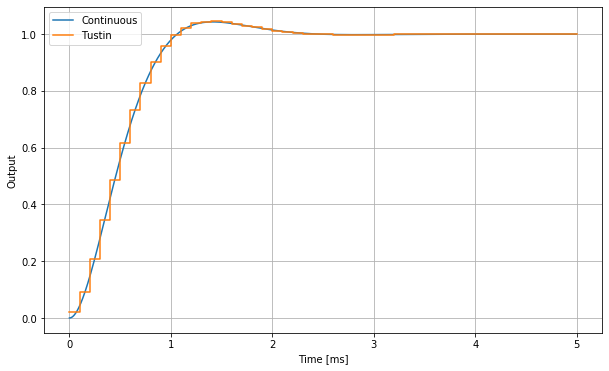

In [10]:
t_0 = np.arange(0, 5e-3, 10e-3 / 2048)
t_d0 = np.arange(0, 5e-3 + T_s, T_s)

y, t = step(sys = G, T = t_0)
y_d, t_d = step(sys = G_d, T  = t_d0)

fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(t * 1000, y, ls = '-', label = 'Continuous')
ax.step(t_d * 1000, y_d, ls = '-', where = 'post', label = 'Tustin')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Output')
ax.grid()
ax.legend()